介紹
------------

實現由Leon A. Gatys、Alexander S. Ecker和Matthias Bethge提出的神經風格算法。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy
import requests

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

載入圖像
=========

在導入風格和內容圖像時。因原始的 PIL 圖像的值介於 0 和 255 之間，但當轉換為 torch 張量時，它們的值將轉換為介於 0 和 1 之間。圖像還需要調整大小以具有相同的尺寸。另外，在 torch 中的神經網絡是使用值從 0 到 1 的張量訓練的。如果用 0 到 255 的張量圖像輸入網絡，則激活的特徵映射將無法感知到預期的內容和風格。

Torch張量，特別是在PyTorch等深度學習框架中使用的張量，通常需要進行正規化以進行有效的訓練。正規化涉及將輸入數據縮放到標準範圍以便進行學習。在圖像數據的情況下，一種常見的做法是將像素值縮放到範圍[0,1]內。通常通過將每個像素值除以最大值（在8位元圖像中為255）來實現。將數據正規化到[0,1]範圍有助於穩定和加速訓練過程，因為它使優化景觀更加均勻，並且防止某些激活函數（如sigmoid）過早飽和。

In [3]:
def download_image(image_url, save_path):
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print("Image downloaded successfully!")
    else:
        print("Failed to download image.")

# content_url = "https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg"
content_url = "https://www.taipeitimes.com/images/2023/07/21/p13-230721-Jade.jpg"
# style_url = "https://anastasiamak.com/wp-content/uploads/2016/03/golden_gate.jpg"
style_url = "https://assets.paintbasket.com/wp-content/uploads/acrylic-autumn-river-landscape-final-1200-80.jpg"

content_path = "/content/content.jpg"
style_path = "/content/style.jpg"

download_image(content_url, content_path)
download_image(style_url, style_path)

Image downloaded successfully!
Image downloaded successfully!


In [4]:
imsize = 512  # 設置圖像大小

# 載入圖像的轉換器
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # 調整圖像大小
    transforms.ToTensor()])  # 將圖像轉換為Tensor格式

# 圖像載入函數
def image_loader(image_name):
    image = Image.open(image_name)  # 打開圖像
    image = loader(image).unsqueeze(0)  # 轉換為Tensor並添加批次維度
    return image.to(device, torch.float)  # 將圖像移到指定的設備上並轉換為float型別

# 載入風格圖像和內容圖像
style_img = image_loader("/content/style.jpg")  # 載入風格圖像
content_img = image_loader("/content/content.jpg")  # 載入內容圖像
print(style_img.size(), content_img.size())  # 打印圖像尺寸
assert style_img.size() == content_img.size(), ""  # 確認風格圖像和內容圖像尺寸一致


torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


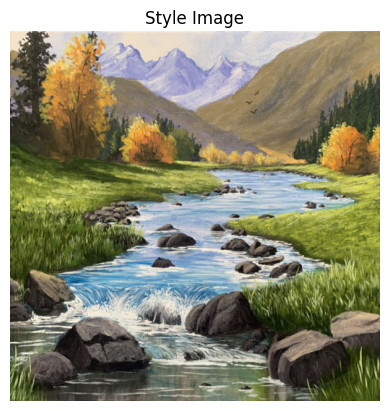

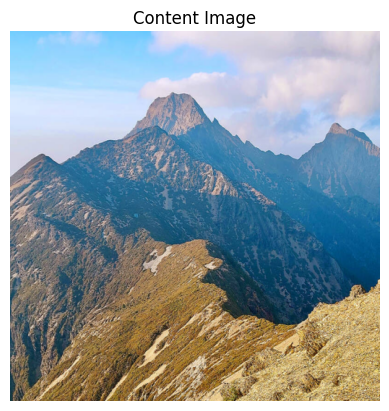

In [5]:
unloader = transforms.ToPILImage()

# 顯示圖像的函數
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)  # 複製並從GPU移到CPU，並去除批次維度
    image = unloader(image)  # 將張量轉換為PIL圖像
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


損失函數
======
內容損失
-------
內容損失是一個函數，表示單個層的內容距離的加權版本。該函數接受網絡處理輸入 $X$ 的層 $L$ 的特徵映射 $F_{XL}$，並返回圖像 $X$ 和內容圖像 $C$ 之間的加權內容距離 $w_{CL}.D_C^L(X,C)$。為了計算內容距離，該函數必須知道內容圖像的特徵映射($F_{CL}$)。我們將此函數實現為一個 torch 模塊，其構造函數以 $F_{CL}$ 為輸入。距離 $|F_{XL} - F_{CL}|^2$ 是兩組特徵映射之間的均方誤差，可以使用 nn.MSELoss 來計算。

In [6]:
# 定義內容損失模組
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()  # 分離目標特徵，避免計算梯度

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)  # 計算均方誤差損失作為內容損失
        return input  # 返回輸入特徵圖

風格損失
==========

風格損失模塊的實現方式與內容損失類似。為了計算風格損失，我們需要計算格拉姆矩陣 $G_{XL}$。格拉姆矩陣是將給定矩陣乘以其轉置矩陣的結果。在這個應用中，給定矩陣是層 $L$ 的特徵映射 $F_{XL}$ 的重塑版本。$F_{XL}$ 被重塑成形成 $\hat{F}_{XL}$ 的 $K$x$N$ 矩陣，其中 $K$ 是層 $L$ 中的特徵映射數量，$N$ 是任意矢量化特徵映射 $F_{XL}^k$ 的長度。例如，$\hat{F}_{XL}$ 的第一行對應於第一個矢量化特徵映射 $F_{XL}^1$。

最後，必須對格拉姆矩陣進行標準化，方法是將矩陣中的每個元素除以矩陣中的總元素數。這種標準化是為了抵消 $\hat{F}_{XL}$ 矩陣中具有較大 $N$ 維度的事實，導致格拉姆矩陣中出現較大的值。這些較大的值將導致梯度下降過程中的前幾層（池化層之前的層）產生更大的影響。由於風格特徵通常存在於網絡的較深層，因此標準化的步驟至關重要。

In [7]:
# 計算 Gram 矩陣的函數
def gram_matrix(input):
    a, b, c, d = input.size()  # 獲取特徵圖的大小
    features = input.view(a * b, c * d)  # 將特徵圖轉換為二維矩陣
    G = torch.mm(features, features.t())  # 計算 Gram 矩陣
    return G.div(a * b * c * d)  # 對 Gram 矩陣進行標準化

In [8]:
# 定義風格損失模組
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()  # 計算目標特徵的 Gram 矩陣並分離出來

    def forward(self, input):
        G = gram_matrix(input)  # 計算輸入特徵圖的 Gram 矩陣
        self.loss = F.mse_loss(G, self.target)  # 計算均方誤差損失作為風格損失
        return input  # 返回輸入特徵圖

導入模型
===================

現在，我們需要導入一個預訓練的神經網絡。我們將使用一個類似於論文中使用的 19 層 VGG 網絡。

PyTorch 對 VGG 的實現是一個分為模塊：`features`（包含卷積和池化層）和 `classifier`（包含全連接層）。我們將使用 `features` 模塊，因為我們需要個別卷積層的輸出來測量內容和風格損失。一些層在訓練期間和評估期間的行為不同，因此我們必須使用 `.eval()` 將網絡設置為評估模式。

In [9]:
# 使用預訓練的 VGG19 模型權重初始化 CNN
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:12<00:00, 46.7MB/s]


另外，VGG 網絡是在每個通道均值為 [0.485, 0.456, 0.406]，標準差為 [0.229, 0.224, 0.225] 的圖像上訓練的。我們將使用這些值對圖像進行歸一化，然後將其傳送到網絡中。

In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).clone().detach()
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).clone().detach()

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)  # 複製並轉換形狀為1x1的張量
        self.std = std.clone().detach().view(-1, 1, 1)  # 複製並轉換形狀為1x1的張量

    def forward(self, img):
        return (img - self.mean) / self.std  # 對輸入圖像進行正規化操作


一個 Sequential 模塊包含一個有序列表的子模塊。例如，vgg19.features 包含一個按深度排序的序列 (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU...)。我們需要在它們所檢測的卷積層之後立即添加我們的內容損失和風格損失層。為此，我們必須創建一個新的 Sequential 模塊，並將內容損失和風格損失模塊正確插入其中。

In [11]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# 風格轉換模型和損失函數獲取函數
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # 正規化層
    normalization = Normalization(normalization_mean, normalization_std)

    # 初始化風格和內容損失列表
    content_losses = []
    style_losses = []

    # 創建模型，將正規化層添加到序列模型中
    model = nn.Sequential(normalization)

    # 初始化層索引
    i = 0
    # 遍歷CNN模型的每一層
    for layer in cnn.children():
        # 如果是卷積層
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        # 如果是ReLU層
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)  # 避免原地修改
        # 如果是最大池化層
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        # 如果是BatchNorm層
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # 將該層添加到模型中
        model.add_module(name, layer)

        # 如果該層在內容層列表中
        if name in content_layers:
            # 添加內容損失
            target = model(content_img).detach()  # 取得目標特徵
            content_loss = ContentLoss(target)  # 創建內容損失
            model.add_module("content_loss_{}".format(i), content_loss)  # 添加到模型
            content_losses.append(content_loss)  # 添加到內容損失列表

        # 如果該層在風格層列表中
        if name in style_layers:
            # 添加風格損失
            target_feature = model(style_img).detach()  # 取得目標特徵
            style_loss = StyleLoss(target_feature)  # 創建風格損失
            model.add_module("style_loss_{}".format(i), style_loss)  # 添加到模型
            style_losses.append(style_loss)  # 添加到風格損失列表

    # 倒序找到最後一個損失層或風格層
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    # 截斷模型至最後一個損失層或風格層
    model = model[:(i + 1)]

    return model, style_losses, content_losses


接下來，輸入圖像。

In [12]:
input_img = content_img.clone()

梯度下降
================

正如該算法的作者 Leon Gatys 在這裡建議的那樣，我們將使用 L-BFGS 算法來運行我們的梯度下降。與訓練一個網絡不同，我們希望訓練輸入圖像以最小化內容/風格損失。我們將創建一個 PyTorch 的 L-BFGS 優化器 `optim.LBFGS`，並將我們的圖像作為要優化的張量傳遞給它。

In [13]:
# 獲取輸入圖像的優化器
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])  # 使用LBFGS優化器
    return optimizer  # 返回優化器

最後，我們必須定義一個執行神經轉移的函數。對於網絡的每一次迭代，它都會被提供一個更新後的輸入並計算新的損失。我們將運行每個損失模塊的 backward 方法來動態計算它們的梯度。優化器需要一個“closure”函數，它重新評估模塊並返回損失。

我們還有一個最後的限制要解決。網絡可能會嘗試優化輸入，使其值超出圖像的0到1的張量範圍。我們可以通過在運行網絡時每次將輸入值校正為0到1之間來解決這個問題。

In [14]:
# 定義風格轉換函數
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=1000,
                       style_weight=1000000, content_weight=1):
        
    print('Building the style transfer model..')
    
    # 獲取風格轉換模型和損失函數
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    
    # 設置 input_img 為需要梯度
    input_img.requires_grad_(True)
    
    # 將模型設置為評估模式
    model.eval()
    
    # 將模型參數設置為不需要梯度
    model.requires_grad_(False)

    # 獲取優化器
    optimizer = get_input_optimizer(input_img)
    
    # 打印消息：優化過程
    print('Optimizing..')
    
    # 初始化運行次數和損失記錄
    run = [0]
    style_loss_record = []
    content_loss_record = []
    
    # 迭代優化
    while run[0] <= num_steps:

        def closure():

            with torch.no_grad():
                input_img.clamp_(0, 1)  # 限制輸入圖像的像素值範圍在 0 到 1 之間

            optimizer.zero_grad()  # 清除梯度
            model(input_img)  # 通過模型獲取輸入圖像的特徵
            style_score = 0  # 初始化風格損失
            content_score = 0  # 初始化內容損失

            # 計算風格損失和內容損失
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight  # 加權風格損失
            content_score *= content_weight  # 加權內容損失

            loss = style_score + content_score  # 計算總損失
            loss.backward()  # 執行反向傳播

            run[0] += 1  # 更新運行次數
            if run[0] % 20 == 0:
                print(".", end='')  # 每20步打印一次"."以顯示進度
                style_loss_record.append(style_score.item())  # 將風格損失記錄到列表中
                content_loss_record.append(content_score.item())  # 將內容損失記錄到列表中

            return style_score + content_score  # 返回風格損失和內容損失的加權和作為優化器的損失


        # 進行一步優化
        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img, style_loss_record, content_loss_record


執行風格轉換

........................................

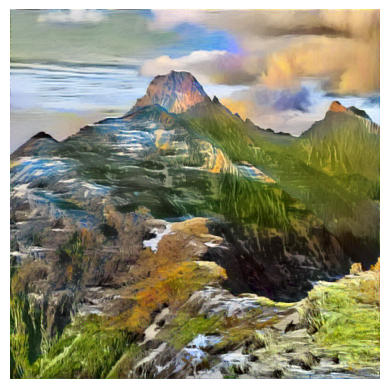

In [15]:
output, style_loss, content_loss = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output)
plt.ioff()
plt.show()

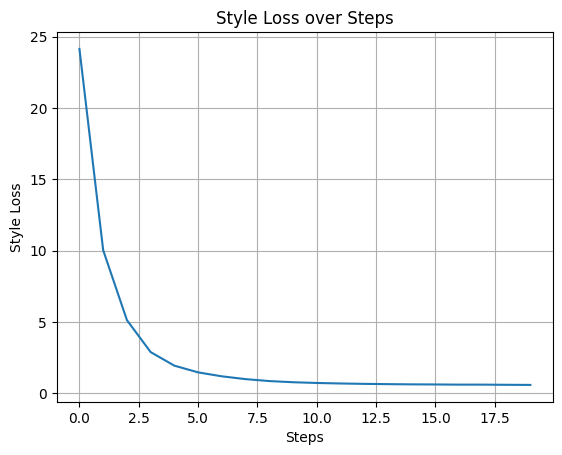

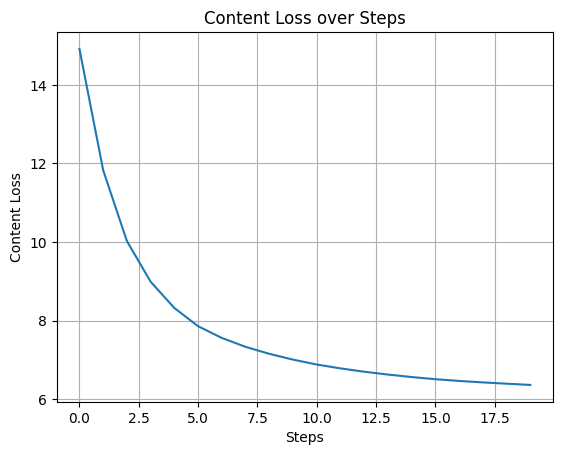

In [16]:
plt.plot(style_loss)
plt.xlabel('Steps')
plt.ylabel('Style Loss')
plt.title('Style Loss over Steps')
plt.grid(True)
plt.show()
plt.plot(content_loss)
plt.xlabel('Steps')
plt.ylabel('Content Loss')
plt.title('Content Loss over Steps')
plt.grid(True)
plt.show()